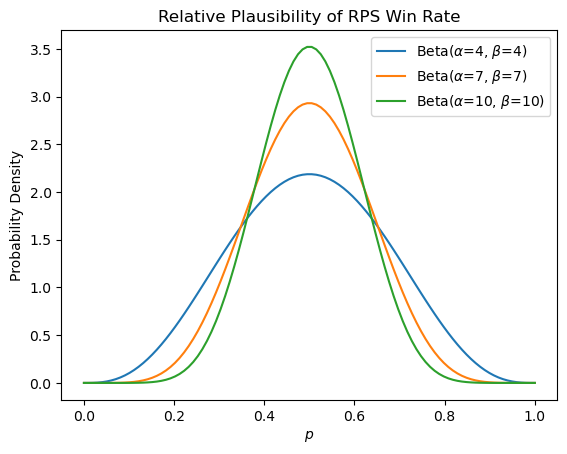

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta, bernoulli

prior_color = "C0"
post_color = "C1"

parameters = [
    (4, 4),
    (7, 7),
    (10, 10)
]

x = np.linspace(0, 1, 100)
plt.figure()

for i, (alpha, beta_val) in enumerate(parameters):
    y = beta.pdf(x, alpha, beta_val)
    label = f'Beta($\\alpha$={alpha}, $\\beta$={beta_val})'
    plt.plot(x, y, label=label)

plt.xlabel("$p$")
plt.ylabel("Probability Density")
plt.title('Relative Plausibility of RPS Win Rate')
plt.legend()
# plt.grid(True)

In [109]:
beta.pdf(0.5, 10, 10) / beta.pdf(0.7, 10, 10)

np.float64(4.802710683776413)

In [110]:
np.random.seed(42)

def simulate_one_outcome(alpha_param, beta_param, N):
    theta = beta.rvs(alpha_param, beta_param)
    y = bernoulli.rvs(theta, size=N)
    return {"theta": theta, "y": y, "sum_y": np.sum(y)}

simulate_one_outcome(alpha_param=10, beta_param=10, N=10)

{'theta': np.float64(0.5499465562958551),
 'y': array([1, 1, 1, 0, 0, 0, 1, 0, 0, 1]),
 'sum_y': np.int64(5)}

In [111]:
def simulate_outcomes(n_outcomes, alpha_param, beta_param, N):
    return pd.DataFrame([
        simulate_one_outcome(alpha_param, beta_param, N)
        for _ in range(n_outcomes)
    ])

In [112]:
# set DGP parameters
alpha_param, beta_param = 10, 10
N = 10

# simulate outcomes from the generative model
outcome_df = simulate_outcomes(1_000, alpha_param, beta_param, N)
outcome_df.head()

,theta,y,sum_y
0,0.500196,"[1, 1, 0, 1, 1, 1, 1, 0, 1, 0]",7
1,0.446240,"[0, 1, 1, 1, 0, 0, 1, 0, 0, 0]",4
2,0.662485,"[1, 1, 0, 0, 0, 0, 1, 0, 1, 1]",5
3,0.515249,"[0, 1, 1, 0, 1, 0, 1, 0, 0, 1]",5
4,0.507255,"[1, 1, 0, 0, 1, 1, 1, 1, 0, 0]",6


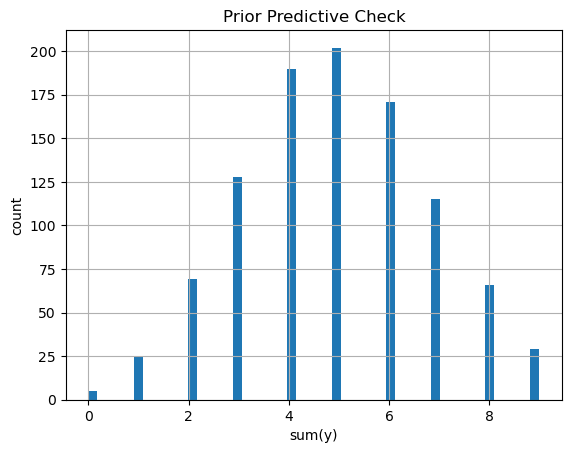

In [113]:
outcome_df.hist("sum_y", bins=50, color=prior_color)
plt.xlabel('sum(y)')
plt.ylabel('count')
plt.title('Prior Predictive Check');

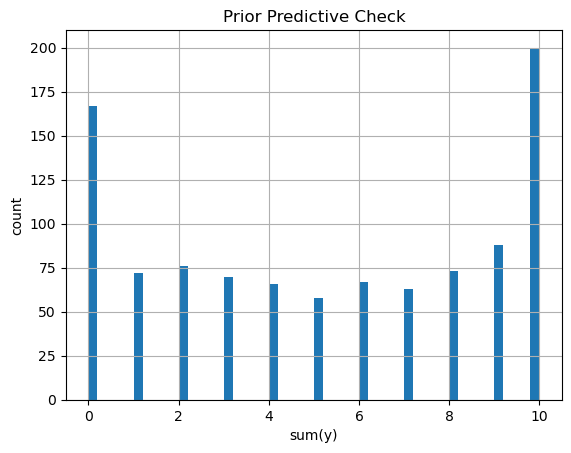

In [114]:
simulate_outcomes(1_000, alpha_param=0.5, beta_param=0.5, N=10).hist("sum_y", bins=50, color=prior_color)
plt.xlabel('sum(y)')
plt.ylabel('count')
plt.title('Prior Predictive Check');

## Inference

## Grid Approximation

$$ \prod_1^n y_i $$

In [75]:
# 0. Defining the observed data

y_obs = np.array([1, 1, 0, 1, 0, 0, 1, 1, 1, 1])
sum_y_obs = np.sum(y_obs)

# 1. Functions for Prior and Likelihood

def prior(theta):
    return beta.pdf(theta, alpha_param, beta_param)

def likelihood(theta, y):
    product_of_likelihoods = 1.0
    for y_i in y:
        product_of_likelihoods *= bernoulli.pmf(y_i, p=theta)
    return product_of_likelihoods

# 2. Function for Joint Density p(y, theta)

def joint_density(theta, y):
    return likelihood(theta, y) * prior(theta)

# 3. Computing the Posterior by "Slicing" and Normalizing

def posterior_from_joint_slice(theta_values, y_observed_data):
    
    # compute grid of p(theta, y_obs) over values of theta and fixed y_obs
    unnormalized_posterior_values = np.array([
        joint_density(theta, y_observed_data) for theta in theta_values
    ])
    
    # numerical integration  to get marginal likelihood p(y_obs
    delta_theta = theta_values[1] - theta_values[0] 
    marginal_likelihood_approx = np.sum(unnormalized_posterior_values * delta_theta)
    
    # p(theta | y_obs) = p(theta, y_obs) / p(y_obs)
    normalized_posterior_values = unnormalized_posterior_values / marginal_likelihood_approx
    
    return normalized_posterior_values

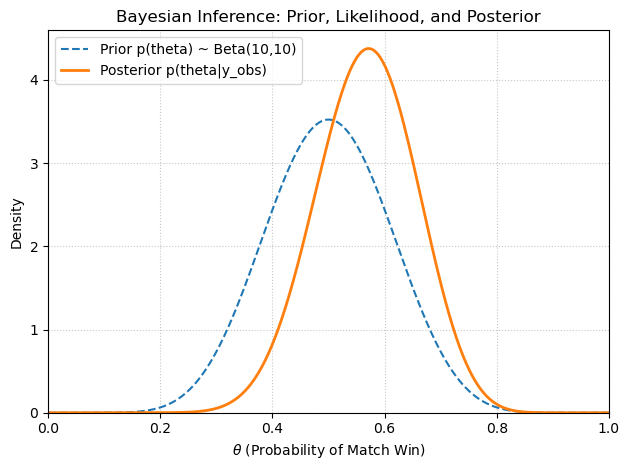

In [115]:
# -----------------------------------------------------------------------------
# Visualization and Comparison
# -----------------------------------------------------------------------------

# Define a grid of theta values
theta_grid = np.linspace(0.001, 0.999, 500) 

# Calculate prior over the grid of theta values
prior_values = np.array([prior(theta) for theta in theta_grid])

# Calculate likelihood values over the grid of theta values and fixed y_obs
likelihood_values = np.array([likelihood(theta, y_obs) for theta in theta_grid])

# Calculate the posterior over the grid of theta values and fixed y_obs
posterior_values = posterior_from_joint_slice(theta_grid, y_obs)

# Plotting
plt.plot(theta_grid, prior_values, label=f'Prior p(theta) ~ Beta({alpha_param},{beta_param})', linestyle='--', color=prior_color)
plt.plot(theta_grid, posterior_values, label=f'Posterior p(theta|y_obs)', color=post_color, linewidth=2)
plt.title('Bayesian Inference: Prior, Likelihood, and Posterior')
plt.xlabel(r'$\theta$ (Probability of Match Win)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.xlim(0, 1)
plt.ylim(bottom=0)
plt.tight_layout()

### Rejection Sampling

Text(0.5, 1.0, 'Samples from the Generative Model')

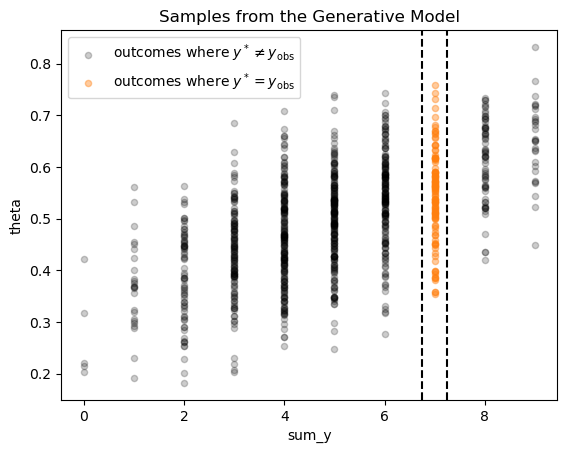

In [123]:
fig, ax = plt.subplots()
outcome_df.query('sum_y != @sum_y_obs').plot(x="sum_y", y="theta", kind="scatter", color="black", alpha=0.2, label="outcomes where $y^* \\ne y_{\\text{obs}}$", ax=ax)
outcome_df.query('sum_y == @sum_y_obs').plot(x="sum_y", y="theta", kind="scatter", color=post_color, alpha=0.4, label="outcomes where $y^* = y_{\\text{obs}}$", ax=ax)
ax.axvline(x=sum_y_obs-0.25, color="black", linestyle='--')
ax.axvline(x=sum_y_obs+0.25, color="black", linestyle='--')
plt.title("Samples from the Generative Model")

In [124]:
# drawing a large number of samples and isolating outcomes where y = y_obs
isolated_outcome_df = simulate_outcomes(10_000, alpha_param, beta_param, N).query('sum_y == @sum_y_obs')

Text(0.5, 1.0, 'Samples from the Posterior')

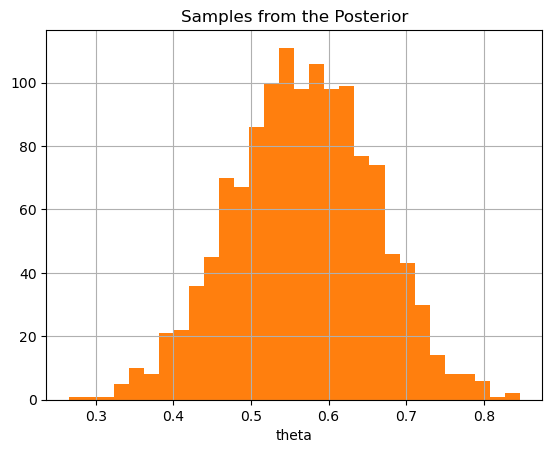

In [126]:
isolated_outcome_df.hist("theta", bins=30, color=post_color)
plt.xlabel("theta")
plt.title("Samples from the Posterior")

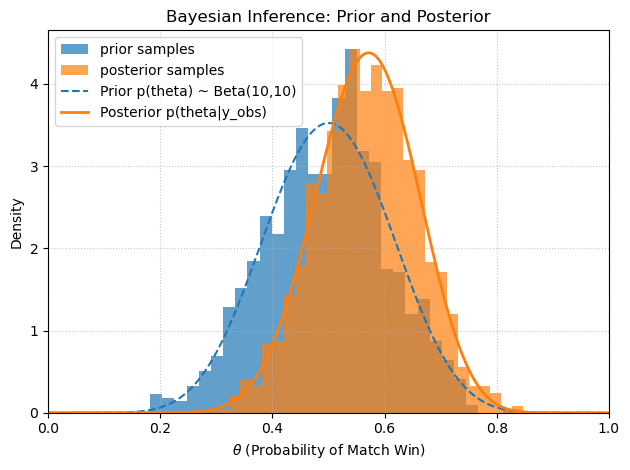

In [136]:

fig, ax = plt.subplots()
outcome_df.hist("theta", density=True, bins=30, alpha=0.7, color=prior_color, label="prior samples", ax=ax)
isolated_outcome_df.hist("theta", density=True, bins=30, alpha=0.7, color=post_color, label="posterior samples", ax=ax)
ax.plot(theta_grid, prior_values, label=f'Prior p(theta) ~ Beta({alpha_param},{beta_param})', linestyle='--', color=prior_color)
ax.plot(theta_grid, posterior_values, label=f'Posterior p(theta|y_obs)', color=post_color, linewidth=2)
plt.title('Bayesian Inference: Prior and Posterior')
plt.xlabel(r'$\theta$ (Probability of Match Win)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.xlim(0, 1)
plt.ylim(bottom=0)
plt.tight_layout()

## Inference

In [7]:
outcomes = [1, 1, 0, 1, 0, 0, 1, 1, 1, 1]

## from scratch

In [69]:
def rps_model_rejection_sampler(observed, n_samples):
    observed_sum = np.array(observed).sum()
    p_values = []
    for _ in range(n_samples):
        p, y = simulate_rps_model_outcome(alpha_param=10, beta_param=10, n=10)
        if y.sum() == observed_sum:
            p_values.append(p)
    return np.array(p_values)

posterior_samples = rps_model_rejection_sampler(outcomes, 20_000)
posterior_samples

array([0.57818545, 0.66496498, 0.39644242, ..., 0.39645356, 0.46427706,
       0.60554682], shape=(2431,))

In [78]:
print(f'point estimate of p: {np.mean(posterior_samples)}')

point estimate of p: 0.5659869306474452


In [80]:
print(f'90% credible interval of p:: {np.quantile(posterior_samples, [0.05, 0.95])}')

90% credible interval of p:: [0.41708583 0.70998003]


In [81]:
print(f'P[p > 0.75]: {np.mean(posterior_samples > 0.75)}')

P[p > 0.75]: 0.015220074043603456


In [92]:
posterior_predictive_samples = bernoulli.rvs(p=posterior_samples[:, None], size=(len(posterior_samples), 10))

In [105]:
print(f'expected wins out of 10: {np.mean(posterior_predictive_samples.sum(axis=1))}')
print(f'90% credible interval for wins out of 10 : {np.quantile(posterior_predictive_samples.sum(axis=1), [0.05, 0.95])}')

expected wins out of 10: 5.686137392019745
90% credible interval for wins out of 10 : [3. 9.]


Text(0.5, 1.0, 'Posterior Predictive Samples')

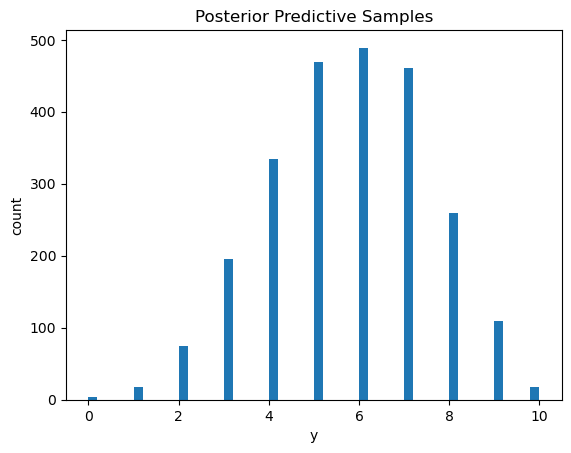

In [95]:
plt.hist(posterior_predictive_samples.sum(axis=1), bins=50);
plt.xlabel('y')
plt.ylabel('count')
plt.title('Posterior Predictive Samples')

## PyMC

In [15]:
import pymc as pm 

with pm.Model() as rps_model:
    p = pm.Beta('p', alpha=10, beta=10)
    pm.Bernoulli('y', p=p, observed=outcomes)

In [23]:
with rps_model:
    prior__predictive_idata = pm.sample_prior_predictive()

Sampling: [p, y]


In [38]:
prior__predictive_idata.prior["p"].sel(chain=0, draw=0).to_numpy()
prior__predictive_idata.prior_predictive["y"].sel(chain=0, draw=0).to_numpy()

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 1])

In [60]:
with rps_model:
    idata_posterior = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


In [63]:
idata_posterior.posterior["p"].mean()

<xarray.DataArray 'p' ()> Size: 8B
array(0.56366858)

array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

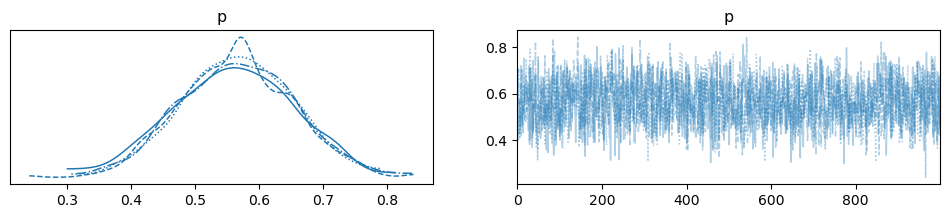

In [10]:
import arviz as az

az.plot_trace(idata)